Import all the necessary libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import calendar
import matplotlib.pyplot as plt
from dateutil.parser import parse
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


Load data from files onto pandas dtaframes

In [2]:
seattle=pd.read_csv('./data/seattle/listings.csv')
seattle_calendar=pd.read_csv('./data/seattle/calendar.csv')


Remove all unwanted columns from dataframe

In [3]:
droppedCols=['listing_url','host_url', 'scrape_id','last_scraped','name', 'summary',
       'space', 'description','neighborhood_overview',
       'notes','thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url']

seattle=seattle.drop(axis=1,columns=droppedCols)

Create month and day field from the date field

In [4]:
seattle_calendar['month']=seattle_calendar['date'].map( lambda x:datetime.strptime(x, '%Y-%m-%d').month)
seattle_calendar['day']=seattle_calendar['date'].map( lambda x:datetime.strptime(x, '%Y-%m-%d').weekday())

Remove the date and price columns as we will not need them

In [5]:
seattle_calendar=seattle_calendar.drop(['date','price'],axis=1)


Convert the 'available' variable into dummy variables

In [6]:
seattle_calendar=pd.get_dummies(seattle_calendar)
seattle_calendar.head()

,listing_id,month,day,available_f,available_t
0,241032,1,0,0,1
1,241032,1,1,0,1
2,241032,1,2,1,0
3,241032,1,3,1,0
4,241032,1,4,1,0


Create a booking rate dataframe. 

In [7]:
booking_rate=seattle_calendar.groupby('listing_id').sum()
booking_rate['rate']=100*(booking_rate['available_f']/(booking_rate['available_t']+booking_rate['available_f']))
booking_rate.drop([ 'month', 'available_t','day'],axis=1,inplace=True)
booking_rate.head()

,available_f,rate
listing_id,,
3335,56.0,15.342466
4291,0.0,0.000000
5682,56.0,15.342466
6606,0.0,0.000000
7369,312.0,85.479452


Create day name and month name from their integer representatives

In [8]:

seattle_calendar['day_name']=seattle_calendar['day'].map(lambda x:  calendar.day_name[x])
seattle_calendar['month_name']=seattle_calendar['month'].map(lambda x:  calendar.month_name[x])

Calculate booking rate per day and plot 

Text(0, 0.5, 'booking rate (%)')

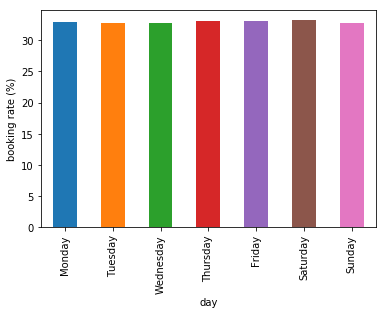

In [9]:
day_g=seattle_calendar.groupby(['day','day_name'])
day_sum=day_g.sum()
day_sum['occupancy_rate']=100*(day_sum['available_f']/(day_sum['available_f']+day_sum['available_t']))
day_sum=day_sum.drop(['listing_id', 'month', 'available_f', 'available_t'],axis=1)
day_sum.reset_index(inplace=True)
ax=day_sum.plot(kind='bar',x='day_name',y='occupancy_rate',legend=False)
ax.set_xlabel("day")
ax.set_ylabel("booking rate (%)")

Calculate booking rate per month and plot

Text(17.200000000000003, 0.5, 'booking rate (%)')

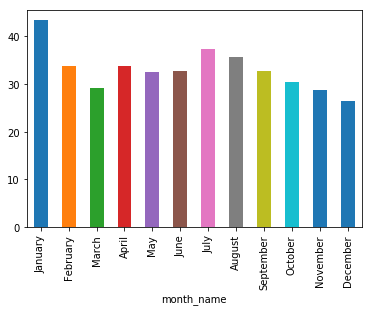

In [10]:

month_g=seattle_calendar.groupby(['month','month_name'])

month_sum=month_g.sum()
month_sum['occupancy_rate']=100*(month_sum['available_f']/(month_sum['available_f']+month_sum['available_t']))
month_sum.drop(['listing_id', 'available_f', 'available_t'],axis=1,inplace=True)
month_sum.reset_index(inplace=True)
max=month_sum.plot(kind='bar',x='month_name',y='occupancy_rate',legend=False)
ax.set_xlabel("month")
ax.set_ylabel("booking rate (%)")

Create a peak season field and set the months of July, August and September as peak season months.

In [11]:
seattle_calendar['peak_season']=seattle_calendar['month'].map( lambda x: 1 if(x <=7 or x<=9)  else 0)

Remove all columns with blank values

In [13]:
seatle=seattle.dropna(axis=1,how='all')


Create a dataframe hold data related the property on airbnb

In [14]:
apartment=seattle[['id','property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet']]
apartment['amenities']=apartment['amenities'].map(lambda x: x.lstrip('{').rstrip('}').replace('\"','')) 
apartment['amenity_count']=apartment['amenities'].map(lambda x:len(x.split(",")))


/Users/MX/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/MX/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Convert money text to float

In [26]:
def strToMoney(df):
    """
    df: a DataFrame containing string features to be convert to float values
    """
    columns=df.select_dtypes(include=['object']).columns
    
    for col in columns:
        df[col]=df[col].map(lambda x: float(x.lstrip('$').replace(',','')) if(isinstance(x, str)) else x)  
    return df

A dataframe to hold cost-related data

In [16]:
cost=seattle[['id','price', 'weekly_price', 'monthly_price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights']]
cost=strToMoney(cost)
cost['longterm_discount']=cost['weekly_price'].map(lambda x: 'No Discount' if x>0 else 'With Discount')

cost.head()

/Users/MX/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,id,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,longterm_discount
0,241032,85.0,NaN,NaN,NaN,NaN,2,5.0,1,365,With Discount
1,953595,150.0,1000.0,3000.0,100.0,40.0,1,0.0,2,90,No Discount
2,3308979,975.0,NaN,NaN,1000.0,300.0,10,25.0,4,30,With Discount
3,7421966,100.0,650.0,2300.0,NaN,NaN,1,0.0,1,1125,No Discount
4,278830,450.0,NaN,NaN,700.0,125.0,6,15.0,1,1125,With Discount


A dataframe to hold availability-related data

In [17]:
availability=seattle[['calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped']]
availability.head()

,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped
0,4 weeks ago,t,14,41,71,346,2016-01-04
1,today,t,13,13,16,291,2016-01-04
2,5 weeks ago,t,1,6,17,220,2016-01-04
3,6 months ago,t,0,0,0,143,2016-01-04
4,7 weeks ago,t,30,60,90,365,2016-01-04


A dataframe to hold review-related data

In [18]:
reviews=seattle[['id','review_scores_rating']]
reviews.head()

,id,review_scores_rating
0,241032,95.0
1,953595,96.0
2,3308979,97.0
3,7421966,NaN
4,278830,92.0


A dataframe to hold cancellation policy data

In [19]:
policies=seattle[['id','requires_license',
       'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count',
       'reviews_per_month']]
policies['reviews_per_month']=policies['reviews_per_month'].fillna(0)
policies.head()


/Users/MX/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,id,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,f,f,moderate,f,f,2,4.07
1,953595,f,f,strict,t,t,6,1.48
2,3308979,f,f,strict,f,f,2,1.15
3,7421966,f,f,flexible,f,f,1,0.00
4,278830,f,f,strict,f,f,1,0.89


Calculate booking rates per cancellation policy

In [20]:
df_cancellation = pd.merge(left=policies, right=booking_rate, how='inner', left_on='id',
right_on='listing_id')
df_cancellation.drop(columns=['id','requires_license', 'instant_bookable', 
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count', 'reviews_per_month'],inplace=True)
df_cancellation_mean=df_cancellation.groupby('cancellation_policy').mean()
df_cancellation_mean['days_booked']=365*(df_cancellation_mean['rate']/100)
df_cancellation_mean=df_cancellation_mean.reset_index()

Join the reviews data table to the booking rate and plot the distribution of review score

/Users/MX/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


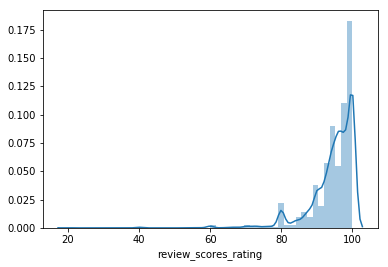

In [21]:
df_reviews = pd.merge(left=reviews, right=booking_rate, how='inner', left_on='id', right_on='listing_id')
df_reviews.dropna(axis=0,how='any',inplace=True)
df_reviews.drop(columns=['id'],inplace=True)
df_reviews.describe()
sns.distplot(df_reviews['review_scores_rating'])

Calculate the booking rate per longterm discount policy

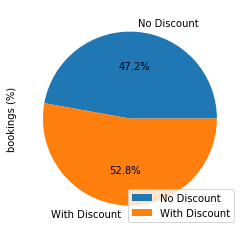

In [22]:
df_discount = pd.merge(left=cost, right=booking_rate, how='inner', left_on='id',
right_on='listing_id')
df_discount.drop(columns=['id','price', 'weekly_price', 'monthly_price', 'security_deposit',
      'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
     'maximum_nights'],inplace=True)
df_discount_mean=df_discount.groupby('longterm_discount').mean()
df_discount_mean['days_booked']=365*(df_discount_mean['rate']/100)
ax=df_discount_mean.plot(kind='pie',x='longterm_discount',y='rate',legend=True,autopct='%1.1f%%')

ax.set_ylabel("bookings (%)")
ax.legend(loc='lower right')

Text(0.5, 0, 'discount types')

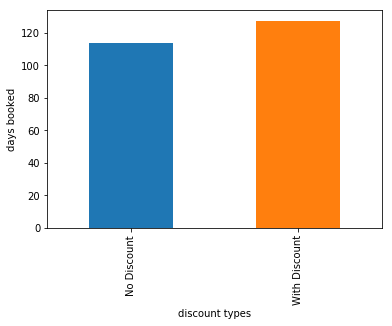

In [23]:
df_discount_mean.reset_index(inplace=True)
ax=df_discount_mean.plot(kind='bar',x='longterm_discount',y='days_booked',legend=False)
ax.set_ylabel("days booked")
ax.set_xlabel("discount types")


Calulate booking rate per number of amenities and plot

Text(0, 0.5, 'booking rate (%)')

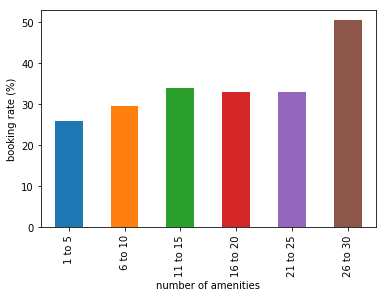

In [24]:
df_amenities = pd.merge(left=apartment, right=booking_rate, how='inner', left_on='id',
right_on='listing_id')
df_amenities.drop(columns=['id', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet'],inplace=True)
df_amenities['amenity_group']=df_amenities['amenity_count'].map(lambda x: '1 to 5' if x<=5 else '6 to 10' if x>5 and x<=10 else '11 to 15' if x>10 and x<=15 else '16 to 20' if x>15 and x<=20 else '21 to 25' if x>20 and x<=25 else '26 to 30' if x>25 and x<=30 else '')
#calculate the mean rate per emenity group
df_amenities_mean=df_amenities.groupby('amenity_group').mean()
df_amenities_mean['days_booked']=365*(df_amenities_mean['rate']/100)
df_amenities_mean=df_amenities_mean.reset_index()
df_amenities_mean=df_amenities_mean.reindex([0,5,1,2,3,4])
df_amenities_mean
#plot data
ax=df_amenities_mean.plot(kind='bar',x='amenity_group',y='rate',legend=False)
ax.set_xlabel("number of amenities")
ax.set_ylabel("booking rate (%)")



Text(0, 0.5, 'number of hosts')

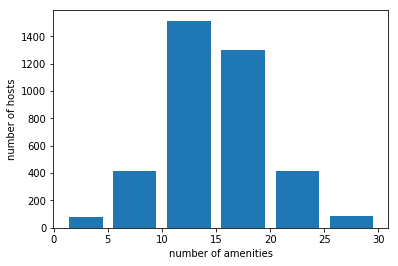

In [25]:
ax=apartment[['amenity_count']].plot(kind='hist',rwidth=0.8,bins=[1,5,10,15,20,25,30],legend=False)
ax.set_xlabel("number of amenities")
ax.set_ylabel("number of hosts")
